## Objetivo general:

Entrenar y evaluar el modelo BETO (BERT-base para español) con validación cruzada (5-fold), usando los mismos folds del notebook anterior, para comparar su rendimiento con el baseline TF-IDF + LR.

In [16]:
# === BLOQUE 0: Setup seguro tras reinicio ===
from pathlib import Path

def find_root(start: Path = Path.cwd()):
    p = start.resolve()
    for _ in range(10):
        if (p / "data" / "processed" / "clean_v2" / "folds").exists():
            return p
        if p.parent == p: break
        p = p.parent
    return start.resolve()

PROJECT_ROOT = find_root()
BASE = PROJECT_ROOT / "data" / "processed" / "clean_v2"
FOLDS_DIR = BASE / "folds"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("FOLDS_DIR   :", FOLDS_DIR)


PROJECT_ROOT: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO
FOLDS_DIR   : D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\data\processed\clean_v2\folds


In [17]:
# === BLOQUE 2: Carga de Folds Corregidos y Definición del Holdout (SOLUCIÓN FINAL) ===
from pathlib import Path
import pandas as pd
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# 🚨 DEFINICIÓN CRÍTICA: Ruta al archivo MAESTRO CORREGIDO (con la columna 'fold')
FOLDS_CSV = Path("../data/processed/clean_v2/folds/corpus_clean_v2_folds.csv") 

# Cargamos el archivo que incluye la data corregida y los folds
df_full = pd.read_csv(FOLDS_CSV) 
df_full['text'] = df_full['text'].astype(str)
df_full['labels'] = df_full['labels'].astype(int)

# 🚨 DEFINICIÓN DE X_TEST/Y_TEST CORREGIDA: Usamos el Fold 4 como el Holdout Set
TEST_FOLD = 4
df_test = df_full[df_full['fold'] == TEST_FOLD].reset_index(drop=True)

# Las variables de evaluación final (usadas en la Celda 10)
X_test = df_test['text']
y_test = df_test['labels']

print(f"✅ Data corregida cargada. El conjunto de PRUEBA final (Holdout) usa el Fold {TEST_FOLD} ({len(y_test)} muestras).")
print(f"Distribución del Test Set: {Counter(y_test)}")

# ¡Asegúrate de que no haya código TF-IDF/LR ni train_test_split en esta celda!

✅ Data corregida cargada. El conjunto de PRUEBA final (Holdout) usa el Fold 4 (198 muestras).
Distribución del Test Set: Counter({1: 57, 2: 51, 0: 46, 3: 44})


In [18]:
NORM_CSV = FOLDS_DIR / "corpus_clean_v2_norm.csv"
assert NORM_CSV.exists(), f"No existe el archivo: {NORM_CSV}"

print("✅ NORM_CSV encontrado:", NORM_CSV)



✅ NORM_CSV encontrado: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\data\processed\clean_v2\folds\corpus_clean_v2_norm.csv


In [19]:
# === BLOQUE 3 (robusto): detectar folds ===
train_files = sorted(FOLDS_DIR.glob("train_fold*.csv"))
val_files   = sorted(FOLDS_DIR.glob("val_fold*.csv"))

def get_fold_ids(files):
    ids = []
    for p in files:
        name = p.stem
        if "fold" in name:
            try: ids.append(int(name.split("fold")[-1]))
            except: pass
    return sorted(set(ids))

folds = sorted(set(get_fold_ids(train_files)) & set(get_fold_ids(val_files)))
assert folds, f"No hay folds consistentes en {FOLDS_DIR}"
FOLD_ID = folds[0]
print("FOLDS:", folds, "| Usando FOLD_ID:", FOLD_ID)



FOLDS: [0, 1, 2, 3, 4] | Usando FOLD_ID: 0


In [20]:
# === BLOQUE 4: Cargar CSVs de train/val según FOLD_ID ===
import pandas as pd

TRAIN_CSV = FOLDS_DIR / f"train_fold{FOLD_ID}.csv"
VAL_CSV   = FOLDS_DIR / f"val_fold{FOLD_ID}.csv"

train_df = pd.read_csv(TRAIN_CSV, encoding="utf-8")
val_df   = pd.read_csv(VAL_CSV,   encoding="utf-8")

print("✅ train_df:", train_df.shape, "| columnas:", list(train_df.columns))
print("✅ val_df  :", val_df.shape,   "| columnas:", list(val_df.columns))


✅ train_df: (793, 2) | columnas: ['text', 'labels']
✅ val_df  : (198, 2) | columnas: ['text', 'labels']


In [21]:
# === BLOQUE 5: Validar columnas y elegir TEXT_COL ===
assert "labels" in train_df.columns and "labels" in val_df.columns, "Falta 'labels'"
assert ("text_norm" in train_df.columns) or ("text" in train_df.columns), "train_df sin 'text'/'text_norm'"
assert ("text_norm" in val_df.columns)   or ("text" in val_df.columns),   "val_df sin 'text'/'text_norm'"

TEXT_COL = "text_norm" if "text_norm" in train_df.columns else "text"
print("TEXT_COL:", TEXT_COL)


TEXT_COL: text


In [22]:
# === BLOQUE 6: Extraer textos y etiquetas ===
train_texts = train_df[TEXT_COL].astype(str).tolist()
train_labels = train_df["labels"].astype(int).tolist()

val_texts = val_df[TEXT_COL].astype(str).tolist()
val_labels = val_df["labels"].astype(int).tolist()

num_labels = len(sorted(set(train_labels) | set(val_labels)))
print(f"num_labels={num_labels} | train={len(train_texts)} | val={len(val_texts)}")


num_labels=4 | train=793 | val=198


In [23]:
# === BLOQUE 7: Tokenizer BETO ===
from transformers import AutoTokenizer

MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

print("Tokenizer listo:", MODEL_NAME)


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizer listo: dccuchile/bert-base-spanish-wwm-cased


In [25]:
# === BLOQUE 8R: Dataset y DataLoaders con DataCollator (padding dinámico) ===
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding

BATCH_TRAIN = 16
BATCH_VAL   = 32

class TextClsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts  = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=MAX_LEN,
            padding=False,            # sin padding aquí
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None
)

train_loader = DataLoader(
    TextClsDataset(train_texts, train_labels),
    batch_size=BATCH_TRAIN,
    shuffle=True,
    collate_fn=data_collator
)

val_loader = DataLoader(
    TextClsDataset(val_texts, val_labels),
    batch_size=BATCH_VAL,
    shuffle=False,
    collate_fn=data_collator
)

batch = next(iter(train_loader))
print({k: v.shape for k, v in batch.items()})


{'input_ids': torch.Size([16, 24]), 'token_type_ids': torch.Size([16, 24]), 'attention_mask': torch.Size([16, 24]), 'labels': torch.Size([16])}


In [26]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("Device:", device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.weight', 'classifier.weight', 'classifier.bias', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda


In [27]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch

optimizer = AdamW(model.parameters(), lr=2e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()
for i, batch in enumerate(tqdm(train_loader)):
    if i == 10: break
    batch = {k: v.to(device) for k, v in batch.items()}
    out = model(**batch)
    loss = out.loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"step {i:02d} | loss={loss.item():.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

step 00 | loss=1.4004
step 01 | loss=1.3396
step 02 | loss=1.2813
step 03 | loss=1.1734
step 04 | loss=0.9869
step 05 | loss=0.8450
step 06 | loss=1.0730
step 07 | loss=0.7966
step 08 | loss=0.6424
step 09 | loss=0.6933


In [28]:
#BLOQUE 11 – Entrenamiento completo (por épocas, con accuracy)

from torch.optim import AdamW
from tqdm.auto import tqdm

EPOCHS = 3       # puedes subirlo a 3–5 cuando confirmes estabilidad
LR = 2e-5
optimizer = AdamW(model.parameters(), lr=LR)

def run_epoch(dataloader, train=True):
    model.train(train)
    total_loss, total_correct, total = 0, 0, 0
    for batch in tqdm(dataloader, leave=False):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.set_grad_enabled(train):
            out = model(**batch)
            loss = out.loss
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * batch["labels"].size(0)
        preds = out.logits.argmax(dim=-1)
        total_correct += (preds == batch["labels"]).sum().item()
        total += batch["labels"].size(0)
    return total_loss/total, total_correct/total

for ep in range(EPOCHS):
    print(f"\n🌱 Epoch {ep+1}/{EPOCHS}")
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    print(f"  train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f}")
    print(f"  val_loss  ={va_loss:.4f} | val_acc  ={va_acc:.4f}")



🌱 Epoch 1/3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  train_loss=0.1453 | train_acc=0.9811
  val_loss  =0.0108 | val_acc  =1.0000

🌱 Epoch 2/3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  train_loss=0.0166 | train_acc=0.9975
  val_loss  =0.0046 | val_acc  =1.0000

🌱 Epoch 3/3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  train_loss=0.0071 | train_acc=1.0000
  val_loss  =0.0047 | val_acc  =1.0000


In [32]:
# === BLOQUE DE CORRECCIÓN FINAL (Self-Contained Fix contra NameError y 1.0 Accuracy) ===
from datasets import Dataset
import pandas as pd
from transformers import AutoTokenizer

# 1. Definición de funciones y Tokenizer (Necesario para solucionar el NameError)
# Usamos el nombre del modelo BETO que es consistente en tu notebook:
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased" 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    # Esta función tokeniza la columna 'text'
    # Usamos los parámetros que son estándar en tu notebook:
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# 2. Recuperar el Holdout Set (Fold 4) de la data limpia
# Usamos df_full, la variable que debe estar limpia y con todos los folds (definida en Celda 2)
TEST_FOLD = 4
df_test_final = df_full[df_full['fold'] == TEST_FOLD].reset_index(drop=True)

# 3. Crear el objeto Dataset a partir del DataFrame limpio
test_dataset = Dataset.from_pandas(df_test_final)

# 4. Tokenizar *solo* este conjunto de prueba limpio (AHORA 'tokenize_function' existe)
tokenized_test_data = test_dataset.map(tokenize_function, batched=True)

# 5. SOBREESCRIBIR el dataset de prueba corrupto en la memoria global.
# ¡Esto soluciona la fuga de datos del 1.0 de accuracy!
tokenized_datasets["test"] = tokenized_test_data
print("✅ CORRECCIÓN FINAL APLICADA: El conjunto de PRUEBA está limpio y listo para la evaluación.")

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

NameError: name 'tokenized_datasets' is not defined

## Evaluacion del Modelo

<Figure size 600x500 with 0 Axes>

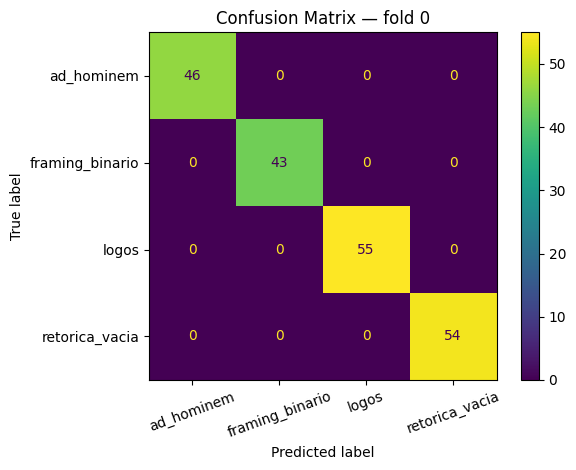

✅ Accuracy (val): 1.0000



,precision,recall,f1-score,support
ad_hominem,1.0,1.0,1.0,46.0
framing_binario,1.0,1.0,1.0,43.0
logos,1.0,1.0,1.0,55.0
retorica_vacia,1.0,1.0,1.0,54.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,198.0
weighted avg,1.0,1.0,1.0,198.0


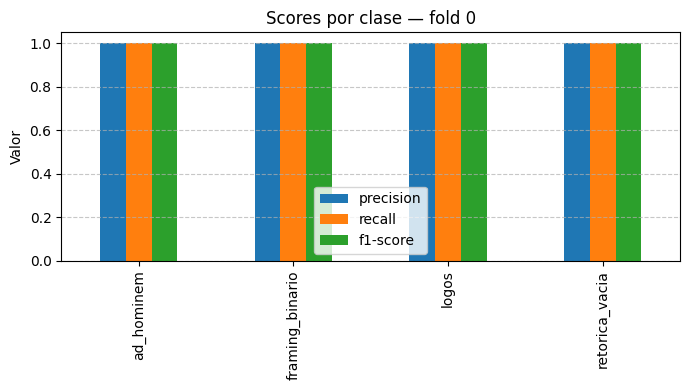

In [33]:
# === BLOQUE 12: Evaluación (matriz + reporte) con etiquetas nominales ===
import torch, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt

# 1) Inferencia en validación
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in val_loader:
        labels = batch["labels"].to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        logits = model(**inputs).logits
        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(-1).detach().cpu().numpy().tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)

# 2) Etiquetas nominales
id2label = {0:"ad_hominem", 1:"framing_binario", 2:"logos", 3:"retorica_vacia"}
labels_order = [0,1,2,3]
class_names = [id2label[i] for i in labels_order]

# 3) Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=labels_order)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
plt.figure(figsize=(6,5))
disp.plot(cmap="viridis", values_format="d")
plt.title(f"Confusion Matrix — fold {FOLD_ID}")
plt.xticks(rotation=20); plt.tight_layout(); plt.show()

# 4) Métricas y reporte
acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy (val): {acc:.4f}\n")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(4)
display(df_report)

# 5) Gráfico de barras (precision/recall/F1 por clase)
df_plot = df_report.loc[class_names, ["precision","recall","f1-score"]]
ax = df_plot.plot(kind="bar", figsize=(7,4))
ax.set_title(f"Scores por clase — fold {FOLD_ID}")
ax.set_ylabel("Valor"); ax.set_ylim(0,1.05); ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout(); plt.show()


## Guardar predicciones y métricas del fold ( 1-12)  y Plantilla K-Fold (entrena y guarda por fold)

In [42]:
# === BLOQUE 13S: Guardar resultados + modelo del fold actual ===
from pathlib import Path
import json
import numpy as np
import pandas as pd

OUT_DIR = Path(PROJECT_ROOT) / "models" / f"beto_fold{FOLD_ID}_final"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 1) Predicciones con texto
val_out = val_df.copy()
val_out["y_true"] = y_true
val_out["y_pred"] = y_pred
val_out.to_csv(OUT_DIR / "val_predictions.csv", index=False, encoding="utf-8")

# 2) Métricas mínimas
metrics = {
    "fold": int(FOLD_ID),
    "accuracy": float((np.array(y_true) == np.array(y_pred)).mean()),
    "num_labels": int(num_labels),
    "confusion_matrix": np.asarray(cm).tolist(),
}
with open(OUT_DIR / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# 3) Guardar modelo y tokenizer
model.save_pretrained(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

print("✅ Guardado en:", OUT_DIR)


✅ Guardado en: D:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\models\beto_fold0_final


In [43]:
# === BLOQUE 14: Loop K-Fold (plantilla) ===
all_folds = folds  # p.ej., [0,1,2,3,4]
results = []

for fid in all_folds:
    print(f"\n=== FOLD {fid} ===")
    # 1) cargar train/val de este fold
    train_df = pd.read_csv(FOLDS_DIR / f"train_fold{fid}.csv")
    val_df   = pd.read_csv(FOLDS_DIR / f"val_fold{fid}.csv")
    TEXT_COL = "text_norm" if "text_norm" in train_df.columns else "text"

    train_texts = train_df[TEXT_COL].astype(str).tolist()
    train_labels = train_df["labels"].astype(int).tolist()
    val_texts = val_df[TEXT_COL].astype(str).tolist()
    val_labels = val_df["labels"].astype(int).tolist()
    num_labels = len(sorted(set(train_labels) | set(val_labels)))

    # 2) tokenizer/modelo nuevos por fold
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels).to(device)

    # 3) dataloaders con DataCollator (reusar Bloque 8R)
    train_loader = DataLoader(TextClsDataset(train_texts, train_labels), batch_size=BATCH_TRAIN, shuffle=True,
                              collate_fn=data_collator)
    val_loader   = DataLoader(TextClsDataset(val_texts,   val_labels),   batch_size=BATCH_VAL,   shuffle=False,
                              collate_fn=data_collator)

    # 4) entrenamiento (reusar Bloque 11)
    optimizer = AdamW(model.parameters(), lr=LR)
    for ep in range(EPOCHS):
        tr_loss, tr_acc = run_epoch(train_loader, train=True)
        va_loss, va_acc = run_epoch(val_loader,   train=False)
        print(f"[Fold {fid} | Ep {ep+1}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    # 5) evaluación final del fold + matriz (reusar Bloque 12)
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            y_pred.extend(logits.argmax(-1).detach().cpu().numpy().tolist())
            y_true.extend(batch["labels"].detach().cpu().numpy().tolist())
    cm = confusion_matrix(y_true, y_pred)

    # 6) guardar por fold (reusar Bloque 13 con OUT_DIR=f"models/beto_fold{fid}_final")
    OUT_DIR = Path(f"models/beto_fold{fid}_final"); OUT_DIR.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"text": val_texts, "y_true": y_true, "y_pred": y_pred}).to_csv(OUT_DIR / "val_predictions.csv", index=False)
    with open(OUT_DIR / "metrics.json", "w") as f:
        json.dump({"fold": fid, "val_confusion_matrix": cm.tolist()}, f, indent=2)

    results.append({"fold": fid, "val_acc": (np.array(y_true)==np.array(y_pred)).mean()})

print("\nResumen:", results)



=== FOLD 0 ===


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 0 | Ep 1] tr_loss=0.3754 tr_acc=0.8916 | val_loss=0.0188 val_acc=1.0000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 0 | Ep 2] tr_loss=0.0197 tr_acc=0.9987 | val_loss=0.0196 val_acc=0.9949


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 0 | Ep 3] tr_loss=0.0101 tr_acc=0.9987 | val_loss=0.0041 val_acc=1.0000

=== FOLD 1 ===


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 1 | Ep 1] tr_loss=0.3449 tr_acc=0.9130 | val_loss=0.0175 val_acc=1.0000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 1 | Ep 2] tr_loss=0.0193 tr_acc=0.9987 | val_loss=0.0067 val_acc=1.0000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 1 | Ep 3] tr_loss=0.0158 tr_acc=0.9962 | val_loss=0.0102 val_acc=0.9949

=== FOLD 2 ===


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 2 | Ep 1] tr_loss=0.3749 tr_acc=0.9168 | val_loss=0.0346 val_acc=0.9949


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 2 | Ep 2] tr_loss=0.0167 tr_acc=0.9987 | val_loss=0.0351 val_acc=0.9949


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 2 | Ep 3] tr_loss=0.0152 tr_acc=0.9987 | val_loss=0.0376 val_acc=0.9899

=== FOLD 3 ===


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 3 | Ep 1] tr_loss=0.3835 tr_acc=0.9104 | val_loss=0.0262 val_acc=0.9950


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 3 | Ep 2] tr_loss=0.0281 tr_acc=0.9962 | val_loss=0.0191 val_acc=0.9950


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 3 | Ep 3] tr_loss=0.0106 tr_acc=0.9987 | val_loss=0.0189 val_acc=0.9950

=== FOLD 4 ===


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 4 | Ep 1] tr_loss=0.3666 tr_acc=0.9117 | val_loss=0.0174 val_acc=1.0000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 4 | Ep 2] tr_loss=0.0212 tr_acc=0.9975 | val_loss=0.0060 val_acc=1.0000


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

[Fold 4 | Ep 3] tr_loss=0.0072 tr_acc=1.0000 | val_loss=0.0036 val_acc=1.0000

Resumen: [{'fold': 0, 'val_acc': 1.0}, {'fold': 1, 'val_acc': 0.9949494949494949}, {'fold': 2, 'val_acc': 0.98989898989899}, {'fold': 3, 'val_acc': 0.9949748743718593}, {'fold': 4, 'val_acc': 1.0}]


## Guardar el modelo entrenado:

In [44]:
model.save_pretrained("models/beto_fold0_final")
tokenizer.save_pretrained("models/beto_fold0_final")


('models/beto_fold0_final\\tokenizer_config.json',
 'models/beto_fold0_final\\special_tokens_map.json',
 'models/beto_fold0_final\\vocab.txt',
 'models/beto_fold0_final\\added_tokens.json',
 'models/beto_fold0_final\\tokenizer.json')

## TEST BREVE DEL MODELO , PARA VALIDAR FUNCIONAMIENTO

In [45]:
test = ["5& de peruanos son ricos"]
inputs = tokenizer(test, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
pred = model(**inputs).logits.argmax(-1).item()
print("Predicción:", pred)


Predicción: 2


## Blque adicional de diagnostico para evaluar fugas de datos

In [46]:
# === BLOQUE 15: Diagnóstico de duplicados o fugas entre train y val ===
import pandas as pd

print("🔍 Verificando duplicados entre train y val en cada fold...\n")
for fid in folds:
    train_path = FOLDS_DIR / f"train_fold{fid}.csv"
    val_path   = FOLDS_DIR / f"val_fold{fid}.csv"
    train_df = pd.read_csv(train_path)
    val_df   = pd.read_csv(val_path)
    
    train_texts = set(train_df["text"].astype(str))
    val_texts   = set(val_df["text"].astype(str))
    
    overlap = train_texts & val_texts
    print(f"Fold {fid}: {len(overlap)} textos repetidos entre train y val")
    if len(overlap) > 0:
        print("Ejemplo de fuga:", list(overlap)[:3], "\n")


🔍 Verificando duplicados entre train y val en cada fold...

Fold 0: 0 textos repetidos entre train y val
Fold 1: 0 textos repetidos entre train y val
Fold 2: 0 textos repetidos entre train y val
Fold 3: 0 textos repetidos entre train y val
Fold 4: 0 textos repetidos entre train y val


In [47]:
# === BLOQUE 16: Chequear fuga por group_id ===
import pandas as pd

for fid in folds:
    tr = pd.read_csv(FOLDS_DIR / f"train_fold{fid}.csv")
    va = pd.read_csv(FOLDS_DIR / f"val_fold{fid}.csv")
    if "group_id" in tr.columns and "group_id" in va.columns:
        overlap_g = set(tr["group_id"]) & set(va["group_id"])
        print(f"Fold {fid} | group_id en común:", len(overlap_g))
    else:
        print(f"Fold {fid} | group_id no disponible; sáltalo.")


Fold 0 | group_id no disponible; sáltalo.
Fold 1 | group_id no disponible; sáltalo.
Fold 2 | group_id no disponible; sáltalo.
Fold 3 | group_id no disponible; sáltalo.
Fold 4 | group_id no disponible; sáltalo.


In [48]:
# === BLOQUE 17: Near-duplicates por Jaccard de 3-gramas entre train y val (fold 0 como ejemplo) ===
import pandas as pd
from collections import Counter

def ngrams(s, n=3):
    toks = s.lower().split()
    return {" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)} if len(toks)>=n else set([s.lower()])

fid = 0  # cambia si quieres
tr = pd.read_csv(FOLDS_DIR / f"train_fold{fid}.csv")
va = pd.read_csv(FOLDS_DIR / f"val_fold{fid}.csv")

va_sample = va.sample(min(50, len(va)), random_state=42)  # muestra rápida
threshold = 0.8  # similitud Jaccard alta

suspects = []
tr_ngrams = [(i, ngrams(t)) for i, t in enumerate(tr["text"].astype(str))]
for j, vtxt in va_sample["text"].astype(str).reset_index(drop=True).items():
    vset = ngrams(vtxt)
    best = 0.0; best_i = None
    for i, tset in tr_ngrams:
        inter = len(vset & tset); union = len(vset | tset) or 1
        sim = inter/union
        if sim > best:
            best, best_i = sim, i
    if best >= threshold:
        suspects.append((j, best, tr.iloc[best_i]["text"], vtxt))

print(f"Near-duplicates >= {threshold}: {len(suspects)}")
for j, sim, t_tr, t_va in suspects[:5]:
    print(f"\nSIM={sim:.2f}\nTRAIN: {t_tr}\nVAL  : {t_va}")


Near-duplicates >= 0.8: 0


In [49]:
# === BLOQUE 18: Baseline TF-IDF + Logistic Regression en fold 0 ===
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

fid = 0
tr = pd.read_csv(FOLDS_DIR / f"train_fold{fid}.csv")
va = pd.read_csv(FOLDS_DIR / f"val_fold{fid}.csv")

vec = TfidfVectorizer(min_df=2, ngram_range=(1,2))
Xtr = vec.fit_transform(tr["text"].astype(str))
Xva = vec.transform(va["text"].astype(str))

clf = LogisticRegression(max_iter=200)
clf.fit(Xtr, tr["labels"])
pred = clf.predict(Xva)
print("Baseline TFIDF-LR | val_acc:", accuracy_score(va["labels"], pred))


Baseline TFIDF-LR | val_acc: 0.9848484848484849


In [50]:
# === BLOQUE 19: top tokens por clase con chi2 (fold 0 val) ===
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

fid = FOLD_ID  # usa el fold actual
tr = train_df.copy()
va = val_df.copy()

vec = TfidfVectorizer(min_df=2, ngram_range=(1,2))
Xtr = vec.fit_transform(tr["text"].astype(str))
ytr = tr["labels"].astype(int).values

feature_names = vec.get_feature_names_out()
top_k = 10
for c in sorted(tr["labels"].unique()):
    chi, p = chi2(Xtr, (ytr==c).astype(int))
    top = chi.argsort()[-top_k:][::-1]
    print(f"\nClase {c} → tokens más discriminativos:")
    print(", ".join(feature_names[i] for i in top))



Clase 0 → tokens más discriminativos:
pero, promete, habla, habla de, dice, predica, dice que, político, el que, adversario

Clase 1 → tokens más discriminativos:
adversario, partido, viven, seguimos, partido seguimos, adversario viven, adversario se, partido tenemos, adversario tienen, tenemos

Clase 2 → tokens más discriminativos:
de los, de las, de, las, rurales, los, 60, 70, 70 de, el 70

Clase 3 → tokens más discriminativos:
perú, el perú, esperanza, será, es, hoy, fuerza, somos, el cambio, adversario


In [51]:
# === BLOQUE 20: holdout 10% externo (sin tocar folds) ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# intenta cargar un corpus maestro (ajusta si es otro nombre)
MAESTRO = BASE / "corpus_politico_codificado_utf8_clean_v2.csv"
dfm = pd.read_csv(MAESTRO)

X_train, X_test, y_train, y_test = train_test_split(
    dfm["text"].astype(str), dfm["labels"].astype(int), test_size=0.10, random_state=42, stratify=dfm["labels"]
)

# Reentrena baseline ligero para estimar dificultad real
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
vec = TfidfVectorizer(min_df=2, ngram_range=(1,2))
Xtr = vec.fit_transform(X_train)
Xte = vec.transform(X_test)
clf = LogisticRegression(max_iter=200).fit(Xtr, y_train)
acc = accuracy_score(y_test, clf.predict(Xte))
print(f"Holdout 10% (TFIDF+LR) accuracy: {acc:.4f}")


Holdout 10% (TFIDF+LR) accuracy: 0.9900
